In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [3]:
aisles_df = pd.read_csv("data/aisles.csv")
print(aisles_df.shape)
aisles_df.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments_df = pd.read_csv("data/departments.csv")
print(departments_df.shape)
departments_df.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
products_df = pd.read_csv("data/products.csv")
print(products_df.shape)
products_df.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
orders_df = pd.read_csv("data/orders.csv")
print(orders_df.shape)
orders_df.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
prior_df = pd.read_csv("data/order_products__prior.csv")
print(prior_df.shape)
prior_df.head(20)

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [10]:
train_df = pd.read_csv("data/order_products__train.csv")
print(train_df.shape)
train_df.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [11]:
products_df_merged = products_df.merge(departments_df, on="department_id").merge(aisles_df, on="aisle_id")
print(products_df_merged.shape)
products_df_merged.head()

(49688, 6)


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


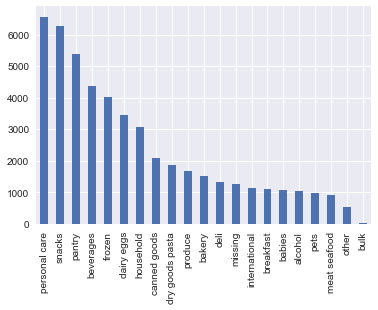

In [12]:
products_df_merged.department.value_counts().plot.bar()

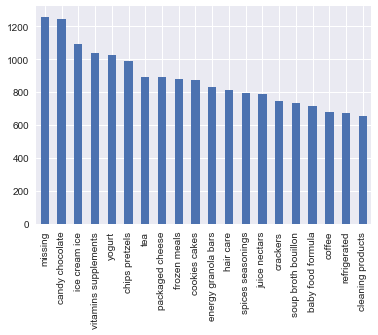

In [10]:
products_df_merged.aisle.value_counts().head(20).plot.bar()

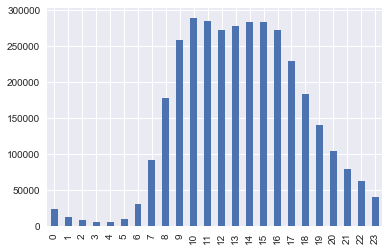

In [13]:
orders_df.order_hour_of_day.value_counts().sort_index().plot.bar()

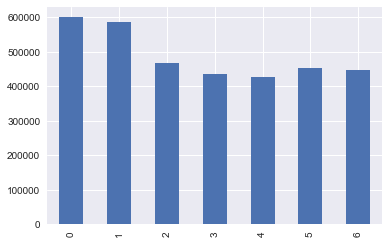

In [14]:
orders_df.order_dow.value_counts().sort_index().plot.bar()

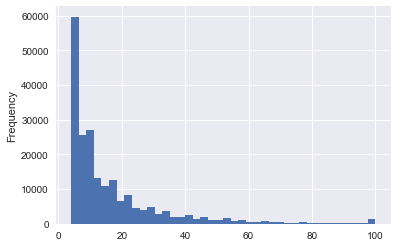

In [19]:
orders_df.user_id.value_counts().plot.hist(bins=40)

In [20]:
orders_df.user_id.value_counts().describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: user_id, dtype: float64

In [13]:
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [35]:
product_counts = prior_df.product_id.value_counts().reset_index()
product_counts.columns = ['product_id', 'product_count']
product_counts = product_counts.merge(products_df_merged, on="product_id")

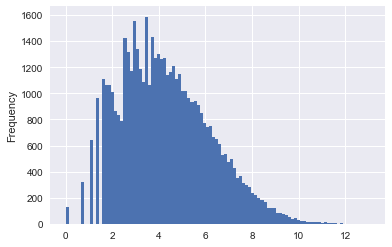

In [41]:
product_counts.product_count.apply(np.log).plot.hist(bins=100)

In [50]:
# create naive submission of reorders from last order
orders_prior = orders_df[orders_df.eval_set == "prior"]
order_maxes = orders_prior.groupby("user_id").order_number.transform(max)
last_orders = orders_prior[orders_prior.order_number == order_maxes]

In [105]:
orders_test = orders_df[orders_df.eval_set == "test"]
last_orders_test = last_orders[last_orders.user_id.isin(orders_test.user_id)]

In [71]:
last_orders_test.shape

(75000, 7)

In [72]:
last_prior_orders_test = prior_df[prior_df.order_id.isin(last_orders_test.order_id)]
last_prior_test_reorders = last_prior_orders_test[last_prior_orders_test.reordered == 1]

In [102]:
last_prior_test_reorders_list = (last_prior_test_reorders.groupby("order_id").product_id
                                 .aggregate(lambda x: " ".join(x.astype(str)))).reset_index()

In [118]:
last_prior_test_reorders_list_all = (last_prior_test_reorders_list
                                 .merge(orders_prior[["user_id", "order_id"]], on="order_id")
                                 .merge(orders_test[["user_id", "order_id"]], on="user_id", how="right"))

In [121]:
submission = pd.DataFrame({"order_id": last_prior_test_reorders_list_all.order_id_y,
                          "products": last_prior_test_reorders_list_all.product_id})

In [123]:
submission.products = submission.products.fillna("None")

In [126]:
submission.to_csv("submissions/naive_lastreorders.csv", index=False)